# ML and data analysis - Sydney Crime Dataset

The dataset contains all outdoor crimes in inner Sydney from 2013 to 2016. In this problem, we try to predict the type of the crime based on the information available about the crime.




## Data exploration

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import seaborn as sns
from google.colab import drive # importing data from my colab

drive.mount('/content/gdrive')

df = pd.read_csv("/content/gdrive/My Drive/aminFiles/sydneyCrimeData.csv")
total_rows = df.shape[0]
print('Total rows:', total_rows)
#df.rename()
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Total rows: 23605


,_id,FID,OBJECTID,bcsrgrp,bcsrcat,lganame,locsurb,locprmc1,locpcode,bcsrgclat,bcsrgclng,bcsrgccde,incyear,incmonth,incday,incsttm,eventyr,eventmth,poisex,poi_age,uniqueID
0,1,0,1,Assault,Non-domestic violence related assault,Sydney,REDFERN,OUTDOOR/PUBLIC PLACE,2016,-33.892390,151.214790,Intersect,2012,August,Monday,16:00,2013,February,,0.000000,50658277
1,2,1,2,Assault,Non-domestic violence related assault,Sydney,SYDNEY,OUTDOOR/PUBLIC PLACE,2000,-33.867700,151.209840,Intersect,2012,October,Tuesday,18:00,2013,February,,0.000000,53061821
2,3,2,3,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,OUTDOOR/PUBLIC PLACE,2011,-33.872671,151.219100,Address,2013,January,Tuesday,1:30,2013,January,,0.000000,50001248
3,4,3,5,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,OUTDOOR/PUBLIC PLACE,2011,-33.870260,151.220190,Intersect,2013,January,Tuesday,3:00,2013,January,,0.000000,49962948
4,5,4,6,Assault,Non-domestic violence related assault,Sydney,SURRY HILLS,OUTDOOR/PUBLIC PLACE,2010,-33.880070,151.215001,Intersect,2013,January,Tuesday,12:51,2013,January,M,50.331964,49970181






### Features in the dataset:


- __bcsrgrp__ : Our main crime category is  which is a type of crime. This is a target variable, or a class label that we are going to predict. 
- __incyear, incmonth, incday, incsttm__ : Date and time of crime
- __locsurb__ : Suburb where crime was commited
- __locpcode__ : Postcode of suburb where crime was commited
- __bcsrgclat__, __bcsrgclng__ : Coordinates of the crime
- __bcsrgccde__ : Place category of location (street, intersection etc.)
- __locpcode__ : Postcode of suburb where crime was commited
- __poiage__, __bcsrgclng__ : Coordinates of the crime


Let's describe the target variable, or the type of crime.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


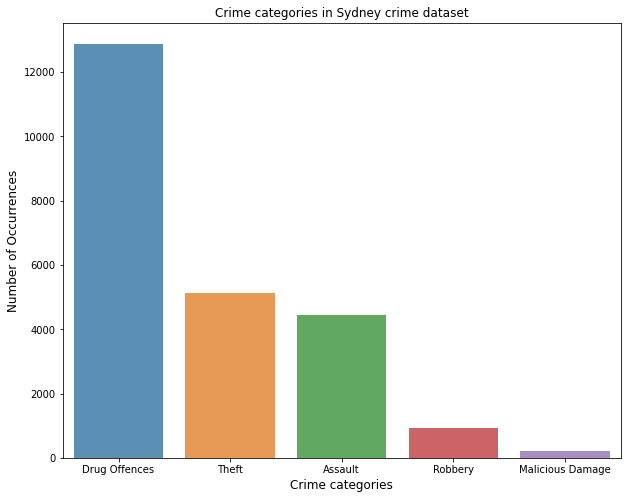

In [6]:
crime_count = df['bcsrgrp'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(crime_count.index, crime_count.values, alpha=0.8)
plt.title('Crime categories in Sydney crime dataset')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Crime categories', fontsize=12)
plt.show()

'bcsrcat' feature has a subcategory of crime and can give more insigths on what types of crimes are done in the area. However, we will remove it later since it directly corresponds to the predicted class feature. 

In [7]:
df.groupby('bcsrgrp')['bcsrcat'].value_counts(normalize=True)

bcsrgrp           bcsrcat                              
Assault           Non-domestic violence related assault    1.000000
Drug Offences     Possession and/or use of cannabis        0.397284
                  Possession and/or use of amphetamines    0.198681
                  Possession and/or use of ecstasy         0.148933
                  Possession and/or use of other drugs     0.128366
                  Possession and/or use of cocaine         0.073652
                  Possession and/or use of narcotics       0.053085
Malicious Damage  Graffiti                                 1.000000
Robbery           Robbery without a weapon                 0.773848
                  Robbery with a weapon not a firearm      0.206860
                  Robbery with a firearm                   0.019293
Theft             Steal from motor vehicle                 0.836906
                  Motor vehicle theft                      0.163094
Name: bcsrcat, dtype: float64

Let's see the type of locations:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


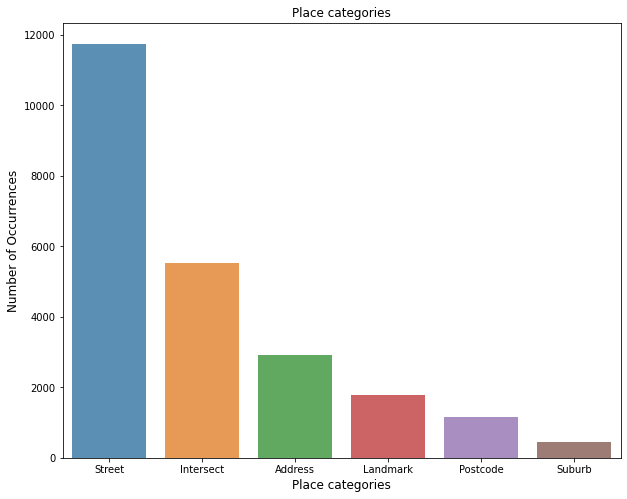

In [8]:
crime_count = df['bcsrgccde'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(crime_count.index, crime_count.values, alpha=0.8)
plt.title('Place categories')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Place categories', fontsize=12)
plt.show()

Let's a number of values for other attributes:

In [9]:
import folium
m = folium.Map(location=[-33.8688, 151.2093 ], zoom_start = 13, tiles = 'cartodbpositron')
#folium.TileLayer('cartodbpositron').add_to(m)
colors = {'Assault': 'green', 'Drug Offences':'blue', 'Malicious Damage':'purple', 'Robbery':'red', 'Theft':'yellow'}
df1 = df
df1 = df[df['bcsrgrp'] == 'Drug Offences']
for index, row in df1.iterrows():     
    folium.CircleMarker([row['bcsrgclat'], row['bcsrgclng']], radius = 1, color = colors[row['bcsrgrp']]).add_to(m)

m


Output hidden; open in https://colab.research.google.com to view.

In [11]:
from folium import plugins
#tationArr = divvyStations[['latitude', 'longitude']].as_matrix()
pointsarr = df[['bcsrgclat', 'bcsrgclng']].to_numpy()
m1 = folium.Map(location=[-33.8688, 151.2093 ], zoom_start = 13, tiles = 'cartodbpositron')
# plot heatmap
m1.add_children(plugins.HeatMap(pointsarr, radius=10))
m1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  


Let's look at other features. For example, 'lganame' and 'locprmc1' are constant across the dataset:

In [12]:
for column in ['lganame','locprmc1']:
    print("---- %s ---" % column)
    print(df[column].value_counts())

---- lganame ---
Sydney    23605
Name: lganame, dtype: int64
---- locprmc1 ---
OUTDOOR/PUBLIC PLACE    23605
Name: locprmc1, dtype: int64


We see it because our dataset consists of all crimes in Greater Sydney made in outdoor or public place. For the prediction analysis, we will remove these features. We also remove features related to different ID's.

We can also see that age and gender columns are not described for all rows in the data:

In [13]:
num_zero_age = df[df['poi_age'] == 0].shape[0]
print('Number of rows without age is %d which is %.2f %% of total' % (num_zero_age, 100.0 * num_zero_age / total_rows))

Number of rows without age is 12976 which is 54.97 % of total


Let's see the age distribution among the known ones:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf865ef710>]],
      dtype=object)

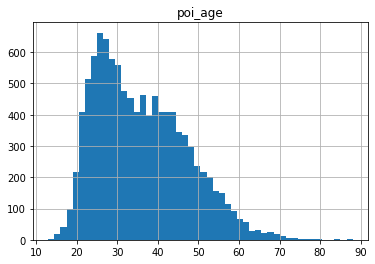

In [14]:
df[df['poi_age'] != 0].hist(column='poi_age', bins = 50)

The same is for genders: more than half of rows do not have information about genders. "U" and "O" mean unknown/other, and describe only a few rows.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


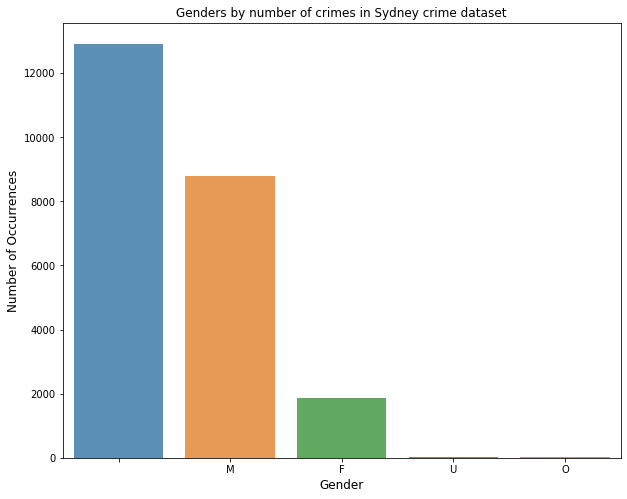

In [15]:
gender_count = df['poisex'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(gender_count.index, gender_count.values, alpha=0.8)
plt.title('Genders by number of crimes in Sydney crime dataset')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

Let's see the relationship of 'locsurb' and 'locpcode'columns which represent suburbs and postcodes:

In [16]:
df.groupby(['locsurb','locpcode']).size()

locsurb          locpcode
ALEXANDRIA       2015         445
ANNANDALE        2038          26
BARANGAROO       2000           6
BEACONSFIELD     2015          36
CAMPERDOWN       2006         129
                 2050         200
CENTENNIAL PARK  2021          22
CHIPPENDALE      2008         259
DARLINGHURST     2010        2090
DARLINGTON       2008         120
DAWES POINT      2000          81
ELIZABETH BAY    2011         139
ERSKINEVILLE     2043         255
EVELEIGH         2015          35
FOREST LODGE     2037          73
GLEBE            2037         787
HAYMARKET        2000        1171
MILLERS POINT    2000         132
MOORE PARK       2021         563
NEWTOWN          2042         450
PADDINGTON       2021         186
POTTS POINT      2011        3262
PYRMONT          2009         518
REDFERN          2016        1554
ROSEBERY         2018         147
RUSHCUTTERS BAY  2011         172
ST PETERS        2044          17
SURRY HILLS      2010        3168
SYDNEY           2000 

Histogram of crimes by time:

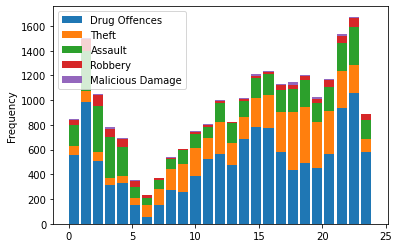

In [17]:


def time_to_hour(time):
    time = time.split(':')
    x = time[0]
    y = time[1]
    x = int(x)
    y = int(y)    
    if y >= 30: 
        x += 1        
    return x
df['hour'] = df["incsttm"].apply(lambda x: time_to_hour(x))
#categories = ['Drug Offences', 'Theft', 'Assault', 'Robbery', 'Malicious Damage']

pd.DataFrame({'Drug Offences': df.groupby('bcsrgrp').get_group('Drug Offences').hour,
              'Theft': df.groupby('bcsrgrp').get_group('Theft').hour,
              'Assault': df.groupby('bcsrgrp').get_group('Assault').hour,
              'Robbery': df.groupby('bcsrgrp').get_group('Robbery').hour,
              'Malicious Damage': df.groupby('bcsrgrp').get_group('Malicious Damage').hour,
             }).plot.hist(bins=25,width=0.8,stacked=True)



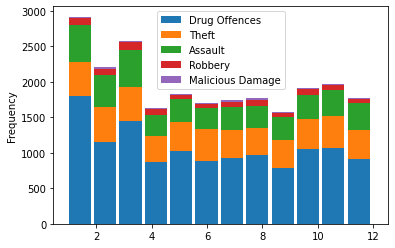

In [18]:
month_map = {'January': 1,
             'February': 2,
             'March': 3,
             'April': 4,
             'May': 5,
             'June': 6,
             'July': 7,
             'August': 8,
             'September': 9,
             'October': 10,
             'November': 11,
             'December': 12}

df['month'] = df["incmonth"].map(month_map)

pd.DataFrame({'Drug Offences': df.groupby('bcsrgrp').get_group('Drug Offences').month,
              'Theft': df.groupby('bcsrgrp').get_group('Theft').month,
              'Assault': df.groupby('bcsrgrp').get_group('Assault').month,
              'Robbery': df.groupby('bcsrgrp').get_group('Robbery').month,
              'Malicious Damage': df.groupby('bcsrgrp').get_group('Malicious Damage').month,
             }).plot.hist(bins=12,width=0.8,stacked=True)



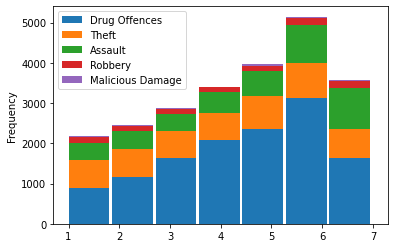

In [19]:
day_map = {'Monday': 1,
          'Tuesday': 2,
          'Wednesday': 3,
          'Thursday': 4,
          'Friday': 5,
          'Saturday': 6,
          'Sunday': 7}
df['day'] = df["incday"].map(day_map)

pd.DataFrame({'Drug Offences': df.groupby('bcsrgrp').get_group('Drug Offences').day,
              'Theft': df.groupby('bcsrgrp').get_group('Theft').day,
              'Assault': df.groupby('bcsrgrp').get_group('Assault').day,
              'Robbery': df.groupby('bcsrgrp').get_group('Robbery').day,
              'Malicious Damage': df.groupby('bcsrgrp').get_group('Malicious Damage').day,
             }).plot.hist(bins=7,width=0.8,stacked=True)

## Feature engineering


As we see, it's almost 1-to-1 correspondence except for Caperdown suburb which is represented by two postcodes. Therefore, postcode feature is redundant. We can mark these suburbs separately and drop the postcode column.

In [20]:
df.loc[df['locpcode'] == 2006, 'locsurb'] = 'CAMPERDOWN_1'
df.loc[df['locpcode'] == 2050, 'locsurb'] = 'CAMPERDOWN_2'
#df.loc[df['locsurb'] == 'CAMPERDOWN_1']

Let's transform date and time features to numerical values:

Next, let's drop all redundant columns.

In [21]:

df.drop(['lganame','eventyr','eventmth','locpcode','bcsrgclat', 'bcsrgclng','incsttm','incday','incmonth', 'locprmc1', 'bcsrcat', 'uniqueID', 'FID', 'OBJECTID'], axis=1, inplace = True)




Since age data is available only for half of rows, we can't do imputation based on its mean. We will create a column which indicates whether age exists, and add Uknonwn gender to represent missing values in Gender. 

In [22]:
df['poisex'] = df['poisex'].map({' ':'U', 'O':'U', 'M':'M', 'F':'F','U':'U'})
df['poi_age_exist'] = df['poi_age'].apply(lambda x: 1 if x>0 else 0)


Next, we factorize categorical variables. We will also do one-hot encoding for other algorithms that do not work with categorical data.

In [23]:
df.bcsrgccde = pd.factorize(df.bcsrgccde)[0]
df.locsurb = pd.factorize(df.locsurb)[0]
df.poisex = pd.factorize(df.poisex)[0]

df.head()


,_id,bcsrgrp,locsurb,bcsrgccde,incyear,poisex,poi_age,hour,month,day,poi_age_exist
0,1,Assault,0,0,2012,0,0.000000,16,8,1,0
1,2,Assault,1,0,2012,0,0.000000,18,10,2,0
2,3,Assault,2,1,2013,0,0.000000,2,1,2,0
3,4,Assault,2,0,2013,0,0.000000,3,1,2,0
4,5,Assault,3,0,2013,1,50.331964,13,1,2,1


# Model selection and training
Now let's train basic Random Forest model


In [24]:
X = df.drop('bcsrgrp', axis = 1)
y = df['bcsrgrp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)




In [25]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)




In [ ]:
#rf_loss = log_loss(y_test, y_pred)
#print('Random Forest Validation Log Loss: ', rf_loss)

acc_score = accuracy_score(y_test, y_pred)
print('Random Forest Accuracy: ', acc_score)


Random Forest Accuracy:  0.6523212470349035


Because we have imbalanced classes, accuracy score isn't representative. Let's look at the confusion matrix:

Confusion matrix, without normalization
[[3184   18    0    0    0]
 [  61 1236    0    0    1]
 [   0    0 1101    1    0]
 [   0    0   53  195    0]
 [  23   20    0    0    9]]


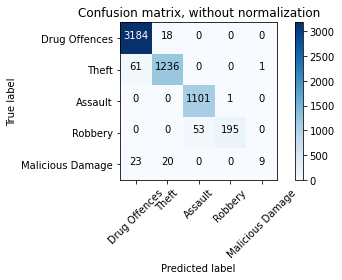

In [26]:
from sklearn.metrics import confusion_matrix
categories = ['Drug Offences', 'Theft', 'Assault', 'Robbery', 'Malicious Damage']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix = confusion_matrix(y_test, y_pred, labels = categories)
import numpy as np

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=categories,
                      title='Confusion matrix, without normalization')

We see that inbalanced classes lead to inaccurate predictions.
Ways to improve it:
1. Oversampling (adding existing examples for minority classes from the dataset)
2. Synthesising new examples from existing ones: Synthetic Minority Oversampling Technique (SMOTE) 